In [1]:
import torch as th
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets
import xarray as xr

import matplotlib.pyplot as plt

# Training and visualizing a logistic regression in pytorch

This notebook is under construction. The main purpose is to load data and train a logistic regression, and to explore regularization.

Moreover, for the trained model, we visualize the learned parameters.

For now, the notebook uses `MNIST` data. In the future, we wish to repeat this process with `proppy.raster`-derived wireless data.

## Loading data as a dataset
The code below loads a pytorch `dataset`. This is what the `proppy.data`-module should produce.

In [52]:
# load training and testing data

train_dataset = datasets.MNIST(root='./data', 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='./data', 
                              train=False, 
                              transform=transforms.ToTensor())

targets  = sorted(list(set(train_dataset.targets.tolist())))

print(f"Number of training samples: {len(train_dataset):,}.")
print(f"Number of testing  samples: {len(test_dataset):,}.")
print("-"*80)
print(f"Datatype of the 1st training sample: {train_dataset[0][0].type()}.")
print(f"Size of the 1st training sample: {train_dataset[0][0].size()}.")
print("-"*80)
print(f"The unique target labels are: {targets}.")

Number of training samples: 60,000.
Number of testing  samples: 10,000.
--------------------------------------------------------------------------------
Datatype of the 1st training sample: torch.FloatTensor.
Size of the 1st training sample: torch.Size([1, 28, 28]).
--------------------------------------------------------------------------------
The unique target labels are: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].


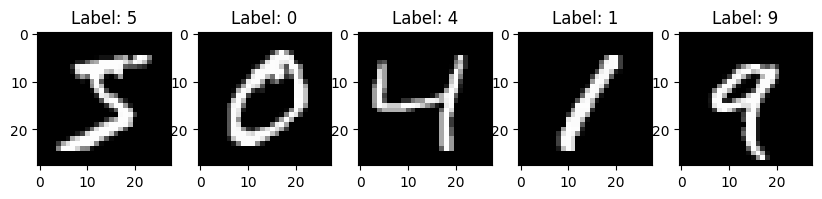

In [53]:
# Plot example images
npics, picsize = 5, 2

fig, ax = plt.subplots(ncols=npics, figsize=(picsize*npics,picsize))
for i in range(npics):
    img = train_dataset[i][0].numpy().reshape(28, 28)
    ax[i].imshow(img, cmap='gray')
    ax[i].set_title(f"Label: {train_dataset[i][1]}")
plt.show()

## Defining and training a model

In [23]:
# initialize dataloader
batach_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batach_size, shuffle=True) 
test_loader = DataLoader(dataset=test_dataset, batch_size=batach_size, shuffle=False)

In [ ]:
# Add weights
weights = 1 / train_dataset.targets.unique(return_counts=True)[-1]

In [46]:
def cross_entropy_sgd(model, train_loader, test_loader, epochs=10, weight=None, **kwargs):
    """Run SGD and report progress."""

    optimizer = th.optim.SGD(model.parameters(), **kwargs)
    objective = th.nn.CrossEntropyLoss(weight=weight)

    losses = []
    accuracies = []

    for epoch in range(epochs):
        for i, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs  = model(images.view(-1, 28*28)) # Not general...
            loss = objective(outputs, labels)
            loss.backward()
            optimizer.step()

        # Save data from run
        losses.append(loss.item())

        # Evaluate accuracy and save
        correct = 0
        for images, labels in test_loader:
            outputs = model(images.view(-1, 28*28))
            _, predicted = th.max(outputs.data, 1)
            correct += (predicted == labels).sum()
        accuracy = 100 * (correct.item()) / len(test_dataset)
        accuracies.append(accuracy)

        # Track completion
        compl = '#' * int(((epoch + 1) / epochs) * 20)
        uncompl = ' ' * (20 - int(((epoch + 1) / epochs) * 20))
        perc = 100 * ((epoch+1) / epochs)
        print(f"[{compl}{uncompl}] {perc:.0f}%  ({1+epoch}/{epochs}). Loss: {loss.item():.3f}. Accuracy: {accuracy:.2f}.", end='\r')

    return losses, accuracies

In [25]:
class LogisticRegression(th.nn.Module):    
    """A simple logistic regression model."""

    def __init__(self, n_inputs, n_outputs):
        super(LogisticRegression, self).__init__()

        self.linear = th.nn.Linear(n_inputs, n_outputs)

    def forward(self, x):
        """Forward function for predictions."""
        y_pred = th.sigmoid(self.linear(x))
        return y_pred

In [26]:
# Make LogisticRegression instance
n_inputs = 28*28
n_outputs = len(targets)
logit = LogisticRegression(n_inputs, n_outputs)

In [27]:
# Run SGD on the model
losses, accuracies = cross_entropy_sgd(
    logit,
    train_loader,
    test_loader,
    epochs=50,
    lr=0.001,
    weight_decay=0.0
)

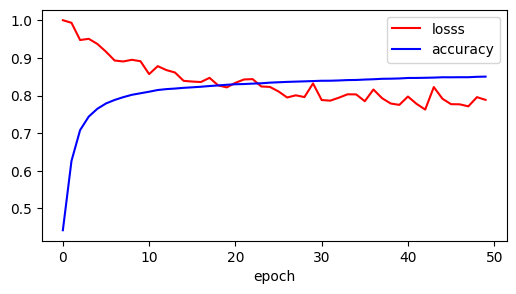

In [28]:
# normalize loss
maxloss = max(losses)
normloss = [l / maxloss for l in losses]

# normalize accuracy
normacc = [a/100 for a in accuracies]

# plot loss and accuracy over epochs
fig, ax = plt.subplots(figsize=(6,3))
ax.plot(normloss, c='r', label='losss')
ax.plot(normacc, c='b', label='accuracy')
ax.set_xlabel('epoch')
plt.legend()
plt.show()

## Visualize the parameter weights

The logistic regression learns one parameter per pixel, per outcome.

It is insightful to view the parameter weights for each outcome.

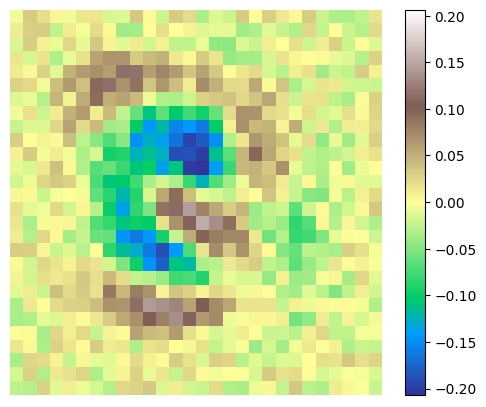

In [29]:
# Visualize the parameters for given outcome

outcome = 3

params = list(logit.parameters())

vals = params[0][outcome, :].detach().numpy()

arr = xr.DataArray(vals.reshape((28, 28)), dims=['y', 'x'])

arr.plot(cmap='terrain', figsize=(6, 5))
plt.axis('off')
plt.show()

## Regularizing the logistic regression
The images above are rather noisy. This indicates that the model is likely overfit.

It might help to regularize.

In [30]:
# Make LogisticRegression instance
logit_ridge = LogisticRegression(n_inputs, n_outputs)

In [48]:
# Run SGD on the model
losses_ridge, accurs_ridge = cross_entropy_sgd(
    logit_ridge,
    train_loader,
    test_loader,
    epochs=50,
    weight=weights,
    lr=0.001,
    weight_decay=0.2 # this regularizes
)

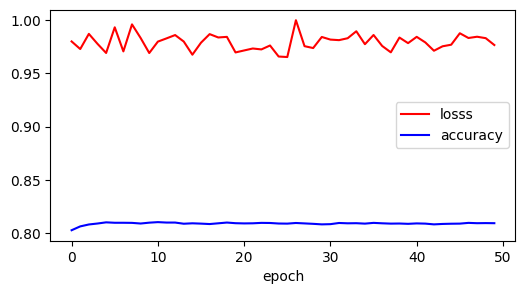

In [49]:
# normalize loss
maxloss = max(losses_ridge)
normloss = [l / maxloss for l in losses_ridge]

# normalize accuracy
normacc = [a/100 for a in accurs_ridge]

# plot loss and accuracy over epochs
fig, ax = plt.subplots(figsize=(6,3))
ax.plot(normloss, c='r', label='losss')
ax.plot(normacc, c='b', label='accuracy')
ax.set_xlabel('epoch')
plt.legend()
plt.show()

Note that the loss is now consistently above the accuracy.
- The loss now includes a penalty.
- It is harder to fit to the training data under a regularized model.

This is not necessarily bad, in fact, it confirms the reuglarization has an effect.

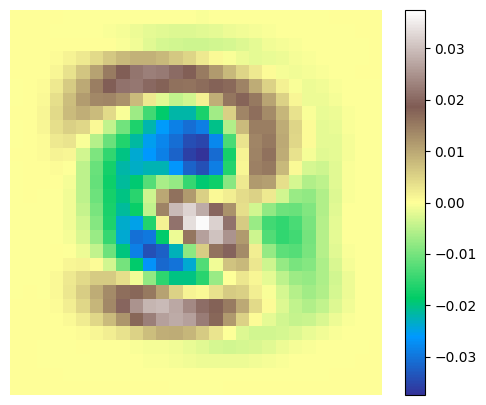

In [50]:
# Visualize the parameters (of regularized model) for given outcome
outcome = 0

params = list(logit_ridge.parameters())

vals = params[0][3, :].detach().numpy()

arr = xr.DataArray(vals.reshape((28, 28)), dims=['y', 'x'])

arr.plot(cmap='terrain', figsize=(6, 5))
plt.axis('off')
plt.show()